In [1]:
import string
import re
import nltk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [2]:
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, twitter_samples, wordnet 
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\ujjwol\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ujjwol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ujjwol\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ujjwol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
stopwords_english = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [4]:
def process_tweet(tweet):

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = nltk.pos_tag(tokenizer.tokenize(tweet))

    tweets_clean = []
    for word in tweet_tokens:
        if (word[0] not in stopwords_english and # remove stopwords
            word[0] not in string.punctuation): # remove punctuation
            stem_word = lemmatizer.lemmatize(word[0], pos_tag_convert(word[1]))
            tweets_clean.append(stem_word)
    return tweets_clean

In [5]:
def pos_tag_convert(nltk_tag: str) -> str:

    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN

In [6]:
def load_tweets():
    all_positive_tweets = twitter_samples.strings('positive_tweets.json')
    all_negative_tweets = twitter_samples.strings('negative_tweets.json')  
    return all_positive_tweets, all_negative_tweets

In [7]:
# Load positive and negative tweets
all_positive_tweets, all_negative_tweets = load_tweets()

# View the total number of positive and negative tweets.
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

The number of positive tweets: 5000
The number of negative tweets: 5000


In [8]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
tweet_number = 4
print('Positive tweet example:')
print(all_positive_tweets[tweet_number])
print('\nNegative tweet example:')
print(all_negative_tweets[tweet_number])

Positive tweet example:
yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

Negative tweet example:
Dang starting next week I have "work" :(


In [9]:
# Process all the tweets: tokenize the string, remove tickers, handles, punctuation and stopwords, stem the words
all_positive_tweets_processed = [process_tweet(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [process_tweet(tweet) for tweet in all_negative_tweets]

In [10]:
# Change the tweet number to any number between 0 and 4999 to see a different pair of tweets.
tweet_number = 4
print('Positive processed tweet example:')
print(all_positive_tweets_processed[tweet_number])
print('\nNegative processed tweet example:')
print(all_negative_tweets_processed[tweet_number])

Positive processed tweet example:
['yeaaah', 'yipppy', 'accnt', 'verify', 'rqst', 'succeed', 'get', 'blue', 'tick', 'mark', 'fb', 'profile', ':)', '15', 'day']

Negative processed tweet example:
['dang', 'start', 'next', 'week', 'work', ':(']


In [11]:
# Split positive set into validation and training
val_pos = all_positive_tweets_processed[4000:]
train_pos = all_positive_tweets_processed[:4000]
# Split negative set into validation and training
val_neg = all_negative_tweets_processed[4000:]
train_neg = all_negative_tweets_processed[:4000]

train_x = train_pos + train_neg 
val_x  = val_pos + val_neg

# Set the labels for the training and validation set (1 for positive, 0 for negative)
train_y = [[1] for _ in train_pos] + [[0] for _ in train_neg]
val_y  = [[1] for _ in val_pos] + [[0] for _ in val_neg]

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 8000 sentences for training.
There are 8000 labels for training.

There are 2000 sentences for validation.
There are 2000 labels for validation.


### Build the Vocabulary


In [12]:
def build_vocabulary(corpus):

    # The vocabulary includes special tokens like padding token and token for unknown words
    # Keys are words and values are distinct integers (increasing by one from 0)
    vocab = {'': 0, '[UNK]': 1} 

    word_index = 2  # Counter for assigning unique integer indices
    
    # Iterate over each tweet in the corpus
    for tweet in corpus:
        # Tokenize the tweet (split into individual words)
        # Assuming tweets are already preprocessed and tokenized
        for word in tweet:
            # Check if word is already in the vocabulary
            if word not in vocab:
                vocab[word] = word_index  # Assign a unique index
                word_index += 1  # Increment counter for next word
    
    return vocab

vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 9535 words

{'': 0, '[UNK]': 1, 'followfriday': 2, 'top': 3, 'engage': 4, 'member': 5, 'community': 6, 'week': 7, ':)': 8, 'hey': 9, 'james': 10, 'odd': 11, ':/': 12, 'please': 13, 'call': 14, 'contact': 15, 'centre': 16, '02392441234': 17, 'able': 18, 'assist': 19, 'many': 20, 'thanks': 21, 'listen': 22, 'last': 23, 'night': 24, 'bleed': 25, 'amazing': 26, 'track': 27, 'scotland': 28, 'congrats': 29, 'yeaaah': 30, 'yipppy': 31, 'accnt': 32, 'verify': 33, 'rqst': 34, 'succeed': 35, 'get': 36, 'blue': 37, 'tick': 38, 'mark': 39, 'fb': 40, 'profile': 41, '15': 42, 'day': 43, 'one': 44, 'irresistible': 45, 'flipkartfashionfriday': 46, 'like': 47, 'keep': 48, 'lovely': 49, 'customer': 50, 'wait': 51, 'long': 52, 'hope': 53, 'enjoy': 54, 'happy': 55, 'friday': 56, 'lwwf': 57, 'second': 58, 'thought': 59, '’': 60, 'enough': 61, 'time': 62, 'dd': 63, 'new': 64, 'short': 65, 'enter': 66, 'system': 67, 'sheep': 68, 'must': 69, 'buy': 70, 'jgh': 71, 'go': 72, 'bayan': 73, ':D

### Convert a Tweet to a Tensor


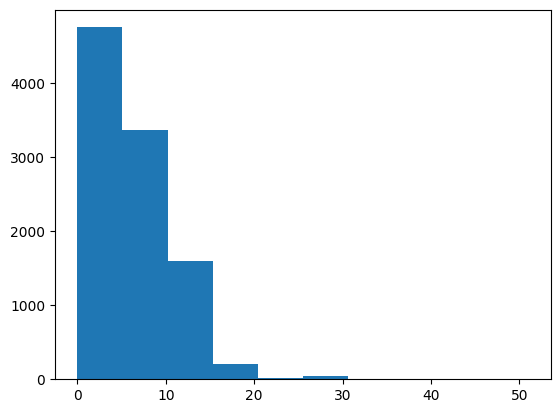

In [13]:
# Tweet lengths
plt.hist([len(t) for t in train_x + val_x]);

In [14]:
def max_length(training_x, validation_x):

    max_len = 0  # Initialize with 0 to ensure it captures non-empty tweets

    # Iterate over each tweet in training and validation sets
    for tweet in training_x:
        tweet_len = len(tweet)  # Get length of current tweet
        max_len = max(max_len, tweet_len)  # Update max_len if current tweet is longer

    for tweet in validation_x:
        tweet_len = len(tweet)
        max_len = max(max_len, tweet_len)
    return max_len

max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 51 tokens.


In [15]:
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    
    # Find the ID of the UNK token, to use it when you encounter a new word
    unk_ID = vocab_dict[unk_token] 
    
    # First convert the words to integers by looking up the vocab_dict
    encoded_tweet = [vocab_dict.get(word, unk_ID) for word in tweet]  # Use get() for unknown words


    # Then pad the tensor with zeroes up to the length max_len
    padded_tensor = encoded_tweet[:max_len] + [0] * (max_len - len(encoded_tweet))

    return padded_tensor

In [16]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]

## Define the structure of the neural network layers


### ReLU


In [17]:
def relu(x):

    activation = np.maximum(x, 0)

    return activation

In [18]:
# Check the output of your function
x = np.array([[-2.0, -1.0, 0.0], [0.0, 1.0, 2.0]], dtype=float)
print("Test data is:")
print(x)
print("\nOutput of relu is:")
print(relu(x))

Test data is:
[[-2. -1.  0.]
 [ 0.  1.  2.]]

Output of relu is:
[[0. 0. 0.]
 [0. 1. 2.]]


### Sigmoid

In [19]:
def sigmoid(x):

    activation = 1 / (1 + np.exp(-x))

    return activation    

In [20]:
# Check the output of your function
x = np.array([[-1000.0, -1.0, 0.0], [0.0, 1.0, 1000.0]], dtype=float)
print("Test data is:")
print(x)
print("\nOutput of sigmoid is:")
print(sigmoid(x))

Test data is:
[[-1000.    -1.     0.]
 [    0.     1.  1000.]]

Output of sigmoid is:
[[0.         0.26894142 0.5       ]
 [0.5        0.73105858 1.        ]]


C:\Users\ujjwol\AppData\Local\Temp\ipykernel_13216\1592352223.py:3: RuntimeWarning: overflow encountered in exp
  activation = 1 / (1 + np.exp(-x))


### Dense Class

In [21]:
class Dense():

    # Please implement '__init__'
    def __init__(self, n_units, input_shape, activation, stdev=0.1, random_seed=42):
        
        # Set the number of units in this layer
        self.n_units = n_units
        # Set the random key for initializing weights
        self.random_generator = np.random.default_rng(seed=random_seed)
        self.activation = activation
    
        # Generate the weight matrix from a normal distribution and standard deviation of 'stdev'
        # Set the size of the matrix w
        w = self.random_generator.normal(scale=stdev, size=(input_shape[1], self.n_units))
        
        self.weights = w
        
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        
        # Matrix multiply x and the weight matrix
        dense = np.dot(x, self.weights)
        # Apply the activation function
        dense = self.activation(dense)
        
        return dense

In [22]:
# random_key = np.random.get_prng()  # sets random seed
z = np.array([[2.0, 7.0, 25.0]]) # input array

# Testing Dense layer 
dense_layer = Dense(n_units=10, input_shape=z.shape, activation=relu)  #sets  number of units in dense layer

print("Weights are:\n",dense_layer.weights) #Returns randomly generated weights
print("Foward function output is:", dense_layer(z)) # Returns multiplied values of units and weights

Weights are:
 [[ 0.03047171 -0.10399841  0.07504512  0.09405647 -0.19510352 -0.13021795
   0.01278404 -0.03162426 -0.00168012 -0.08530439]
 [ 0.0879398   0.07777919  0.00660307  0.11272412  0.04675093 -0.08592925
   0.03687508 -0.09588826  0.08784503 -0.00499259]
 [-0.01848624 -0.06809295  0.12225413 -0.01545295 -0.04283278 -0.03521336
   0.05323092  0.03654441  0.04127326  0.0430821 ]]
Foward function output is: [[0.21436609 0.         3.25266507 0.59085808 0.         0.
  1.61446659 0.17914382 1.64338651 0.87149558]]


### Model

In [23]:
def create_model(num_words, embedding_dim, max_len):

    tf.random.set_seed(123)
        
    model = tf.keras.Sequential([
        # Embedding layer with specified size and input length
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_len),
        # GlobalAveragePooling1D layer
        tf.keras.layers.GlobalAveragePooling1D(),
        # Dense layer with 1 unit and sigmoid activation for binary classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 
    
    # Compile the model with binary_crossentropy loss, adam optimizer, and accuracy metric
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [24]:
# Create the model
model = create_model(num_words=num_words, embedding_dim=16, max_len=max_len)

print('The model is created!\n')

The model is created!



In [25]:
# Prepare the data
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

print('The data is prepared for training!\n')

# Fit the model
print('Training:')
history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

The data is prepared for training!

Training:
Epoch 1/20
250/250 [==============================] - 2s 5ms/step - loss: 0.6833 - accuracy: 0.6438 - val_loss: 0.6674 - val_accuracy: 0.9855
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 0.6321 - accuracy: 0.9496 - val_loss: 0.5962 - val_accuracy: 0.9760
Epoch 3/20
250/250 [==============================] - 1s 3ms/step - loss: 0.5380 - accuracy: 0.9868 - val_loss: 0.4962 - val_accuracy: 0.9890
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 0.4300 - accuracy: 0.9901 - val_loss: 0.3945 - val_accuracy: 0.9935
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 0.3325 - accuracy: 0.9942 - val_loss: 0.3080 - val_accuracy: 0.9920
Epoch 6/20
250/250 [==============================] - 1s 3ms/step - loss: 0.2543 - accuracy: 0.9945 - val_loss: 0.2410 - val_accuracy: 0.9955
Epoch 7/20
250/250 [==============================] - 1s 3ms/step - loss: 0.1952 - accuracy: 0.9955 - 

## Evaluate the model


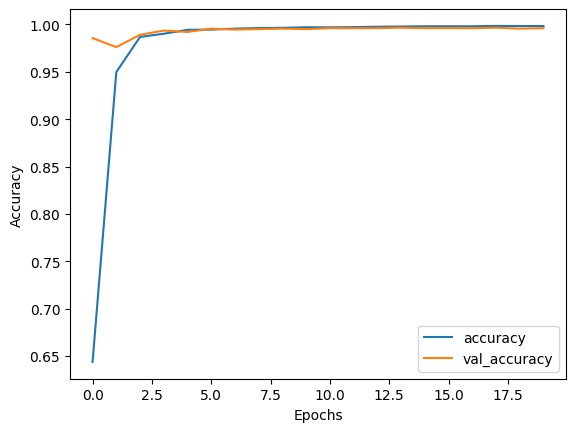

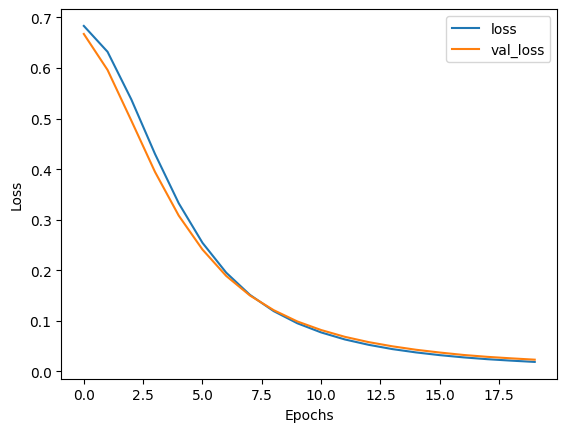

In [26]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

### Predict on Data


In [27]:
# Prepare an example with 10 positive and 10 negative tweets.
example_for_prediction = np.append(val_x_prepared[0:10], val_x_prepared[-10:], axis=0)

# Make a prediction on the tweets.
model.predict(example_for_prediction)

1/1 [==============================] - 0s 82ms/step


array([[0.8991293 ],
       [0.9944587 ],
       [0.9970778 ],
       [0.9524996 ],
       [0.9976879 ],
       [0.99620664],
       [0.9920701 ],
       [0.9792543 ],
       [0.99844587],
       [0.99834955],
       [0.01050258],
       [0.04125416],
       [0.01293042],
       [0.01649664],
       [0.0174144 ],
       [0.00621743],
       [0.01581888],
       [0.00837427],
       [0.02295751],
       [0.0317692 ]], dtype=float32)

## Test With Own Input


In [28]:
def get_prediction_from_tweet(tweet, model, vocab, max_len):
    tweet = process_tweet(tweet)
    tweet = padded_sequence(tweet, vocab, max_len)
    tweet = np.array([tweet])

    prediction = model.predict(tweet, verbose=False)
    
    return prediction[0][0]

In [29]:
unseen_tweet = '@DLAI @NLP_team_dlai OMG!!! what a daaay, wow, wow. This AsSiGnMeNt was gr8. :)'

prediction_unseen = get_prediction_from_tweet(unseen_tweet, model, vocab, max_len)
print(f"Model prediction on unseen tweet: {prediction_unseen}")

Model prediction on unseen tweet: 0.9935685396194458


In [30]:
graded_very_positive_tweet = 'Feeling incredibly grateful for all the amazing people in my life. You make every day brighter.:)'


In [31]:
# Test graded_very_positive_tweet tweet
prediction = get_prediction_from_tweet(graded_very_positive_tweet, model, vocab, max_len)
if prediction > 0.99:
    print("\033[92m All tests passed")
else:
    print("The model thinks your tweet is not positive enough.\nTry figuring out what makes some of the tweets in the validation set so positive.")

 All tests passed


## Word Embeddings


In [32]:
# Get the embedding layer
embeddings_layer = model.layers[0]

# Get the weights of the embedding layer
embeddings = embeddings_layer.get_weights()[0]

print(f"Weights of embedding layer have shape: {embeddings.shape}")

Weights of embedding layer have shape: (9535, 16)


In [33]:
# PCA with two dimensions
pca = PCA(n_components=2)

# Dimensionality reduction of the word embeddings
embeddings_2D = pca.fit_transform(embeddings)

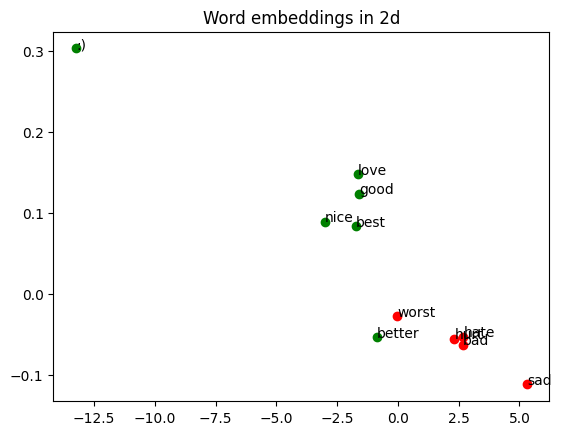

In [34]:
#Selection of negative and positive words
neg_words = ['bad', 'hurt', 'sad', 'hate', 'worst']
pos_words = ['best', 'good', 'nice', 'love', 'better', ':)']

#Index of each selected word
neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(embeddings_2D[neg_n][:,0], embeddings_2D[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (embeddings_2D[neg_n][i,0], embeddings_2D[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(embeddings_2D[pos_n][:,0], embeddings_2D[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(embeddings_2D[pos_n][i,0], embeddings_2D[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()